# This example replicates all the results for the 2D experiments in the paper titled "Generalizable motion planning via operator learning"

### This notebook relies on a series of datasets available on Hugging Face (See README of repo). Please download them and place them in the dataset directory relative to this path.  ##

Please feel free to email lbhan@ucsd.edu if you have any issues or make a github issue!

In [1]:
# Preliminary packages
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from timeit import default_timer
from functools import reduce
from pathlib import Path
import operator
import math
from time import time
from prettytable import PrettyTable
from scipy.ndimage import distance_transform_edt

from utilities.losses import LpLoss
from utilities.normalizers import GaussianNormalizer
from utilities.plotting import set_size

# Sets default device to CUDA. Set to CPU if no GPU access
torch.set_default_device('cuda')

# SETUP PLOTTING FORMATTING
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)

from models.fnoMultiGoal import FNO2dMultiGoal
from models.dafnoMultiGoal import DAFNO2dMultiGoal
from models.deepnormMultiGoal import DEEPNORM2dMultiGoal

# Needed for approximating the SDF solution
from models.fno import FNO2d

torch.cuda.empty_cache()

/home/luke/Planning_Operator/examples/utilities/losses.py:10: SyntaxWarning: invalid escape sequence '\s'
  """


In [2]:
# Load different set of models for training
savepaths = ["FNOMultiGoal", "DAFNOMultiGoal", "DeepnormMultiGoal", "DeepnormMultiGoal"]

model_classes = [FNO2dMultiGoal(4,1, 8,8,16),\
                 DAFNO2dMultiGoal(4, 8,8, 16),\
                 DEEPNORM2dMultiGoal(4, 8,8,16),\
                 DEEPNORM2dMultiGoal(4, 8,8,16)]

# controls whether or not the mask function in DAFNO is applied
mask_func_arr = [lambda a: 1, lambda a: a, lambda a: a,  lambda a: a]

In [94]:
# Load and build normalized torch datasets
dirPath = 'dataset/synthetic/64x64/'
mask = np.load(dirPath + 'mask.npy')
mask = torch.tensor(mask, dtype=torch.float).cuda()
dist_in = np.load(dirPath + 'dist_in.npy')
dist_in = torch.tensor(dist_in, dtype=torch.float).cuda()
goals = np.load(dirPath + 'goal.npy')
goals = torch.tensor(goals, dtype=torch.int).cuda()
def smooth_chi(mask, dist, smooth_coef):
    return torch.mul(torch.tanh(dist * smooth_coef), (mask - 0.5)) + 0.5
input = smooth_chi(mask, dist_in, 5)
output = np.load(dirPath + 'output.npy')
output = torch.tensor(output, dtype=torch.float).cuda()

nData = len(input)
nTrain = int(nData * 0.8)
nTest = int(nData*0.2)
batch_size=20
mask_train = mask[:nTrain]
mask_test = mask[-nTest:]
goals_train = goals[:nTrain]
goals_test = goals[-nTest:]
chi_train = input[:nTrain]
chi_test = input[-nTest:]
y_train = output[:nTrain]
y_test = output[-nTest:]
print(nTest, nTrain)
mask_train = mask_train.reshape(nTrain, input.shape[1], input.shape[2], 1)
mask_test = mask_test.reshape(nTest, input.shape[1], input.shape[2], 1)
goals_train = goals_train.reshape(nTrain, 2)
goals_test = goals_test.reshape(nTest, 2)
chi_train = chi_train.reshape(nTrain, input.shape[1], input.shape[2], 1)
chi_test = chi_test.reshape(nTest, input.shape[1], input.shape[2], 1)

y_train = y_train.reshape(nTrain, input.shape[1], input.shape[2], 1)
y_test = y_test.reshape(nTest, input.shape[1], input.shape[2], 1)
        
trainData = DataLoader(TensorDataset(mask_train, chi_train, goals_train, y_train), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(mask_test, chi_test, goals_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
trainDataSDF = DataLoader(TensorDataset(mask_train, dist_in[:nTrain]), batch_size=batch_size, shuffle=True,  generator=torch.Generator(device='cuda'))
testDataSDF = DataLoader(TensorDataset(mask_test, dist_in[-nTest:]), batch_size=batch_size, shuffle=True,  generator=torch.Generator(device='cuda'))

200 800


# 1. Training the neural operators for approximating the Eikonal Solution for the Value Function
### Note, this is not necessary if one downloads the models as instructed in the README and prefers to use pretrained models

In [109]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul,
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

# Train value function model
def train_model(lr, gamma, wd, batch_size, epochs, scheduler_step, mask_func,loss_type, normalizer,\
                model, trainData, testData, print_output, save_file, file_path):
    # Setup optimizers
    loss_func = LpLoss(d=2, p=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=gamma)

    # Setup data collection
    training_losses = []
    test_losses = []
    train_time_arr = []
    best_model_weights = None
    best_training_loss = np.inf
    best_test_loss = np.inf
    best_epoch = None

    # Print header
    print("Training model", file_path)
    print("Epoch", "Epoch time", "Train loss", "Test loss")

    for ep in range(epochs):
        model.train()

        # Training
        t1 = default_timer()
        train_loss = 0
        samples_train = 0
        for mask, chi, goals, y in trainData:
            mask.cuda(), chi.cuda(), y.cuda()
            # Setup training
            optimizer.zero_grad()

            # Forward pass
            out = model(chi, goals)
            if normalizer is not None:
                out = normalizer.decode(out) * mask_func(mask)
                y = normalizer.decode(y) * mask_func(mask)
            else:
                out = out*mask_func(mask)
            # PINN loss
            if loss_type == "PINN":
                grad_out = torch.linalg.vector_norm(torch.stack(list(torch.gradient(out.reshape(out.shape[0], out.shape[1], out.shape[2]), dim=[1, 2])), dim=0), dim=0)
                grad_y = torch.linalg.vector_norm(torch.stack(list(torch.gradient(y.reshape(out.shape[0], out.shape[1], out.shape[2]), dim=[1, 2])), dim=0), dim=0)
                # set boundary gradients to zero
                grad_mask = grad_y.clone()
                grad_mask[grad_mask >= 1.01] = 0
               
                loss =loss_func(out.view(y.shape[0], y.shape[1], y.shape[2]), y.view(y.shape[0], y.shape[1], y.shape[2])) + \
                0.05*loss_func((grad_out*grad_mask).view(batch_size, y.shape[1], y.shape[2]),grad_mask.view((batch_size, y.shape[1], y.shape[2])))
            else:
                loss =loss_func(out.view(y.shape[0], y.shape[1], y.shape[2]), y.view(y.shape[0], y.shape[1], y.shape[2])) 
            train_loss += loss.item()
            samples_train += y.shape[0]

            # Backprop
            loss.backward()
            optimizer.step()       
        scheduler.step()
        model.eval()
        test_loss = 0
        loss = 0
        t2 = default_timer()
        # Testing
        samples_test = 0
        with torch.no_grad():
            for mask, chi, goals, y in testData:
                out = model(chi, goals)
                if normalizer is not None:
                    out = normalizer.decode(out) * mask_func(mask)
                else:
                    out = out*mask_func(mask)
                # PINN loss
                if loss_type == "PINN":
                    grad_out = torch.linalg.vector_norm(torch.stack(list(torch.gradient(out.reshape(out.shape[0], out.shape[1], out.shape[2]), dim=[1, 2])), dim=0), dim=0)
                    grad_y = torch.linalg.vector_norm(torch.stack(list(torch.gradient(y.reshape(out.shape[0], out.shape[1], out.shape[2]), dim=[1, 2])), dim=0), dim=0)
                    # set boundary gradients to zero
                    grad_mask = grad_y.clone()
                    grad_mask[grad_mask >= 1.01] = 0
                   
                    loss =loss_func(out.view(y.shape[0], y.shape[1], y.shape[2]), y.view(y.shape[0], y.shape[1], y.shape[2])) + \
                    0.05*loss_func((grad_out*grad_mask).view(batch_size, y.shape[1], y.shape[2]),grad_mask.view((batch_size, y.shape[1], y.shape[2])))
                else:
                    loss =loss_func(out.view(y.shape[0], y.shape[1], y.shape[2]), y.view(y.shape[0], y.shape[1], y.shape[2])) 
                test_loss += loss.item()
                samples_test += y.shape[0]
        # Collect data and setup best model
        train_loss /= samples_train
        test_loss /= samples_test
        training_losses.append(train_loss)
        test_losses.append(test_loss)
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_training_loss = train_loss
            best_epoch = ep   
            best_model_weights = model.state_dict()

        t2 = default_timer()
        train_time_arr.append(t2-t1)
        if ep%10 == 0 and print_output:
            print(ep, t2-t1, train_loss, test_loss)

    if save_file:
        Path(file_path).mkdir(parents=True, exist_ok=True)
        np.savetxt(file_path + "/training_losses.txt", training_losses)
        np.savetxt(file_path + "/test_losses.txt", test_losses)
        np.savetxt(file_path + "/training_times.txt", train_time_arr)
        torch.save(best_model_weights, file_path + "/best_model.pt")
        f = open(file_path + "/aggregate_results.txt", "w")
        f.write("ModelParameters: " + str(count_params(model)) + "\n")
        f.write("BestL2TrainingError: " + str(best_training_loss) + "\n")
        f.write("BestL2TestingError: " + str(best_test_loss) + "\n")
        f.write("BestEpoch: " + str(best_epoch) + "\n")
        f.write("TotalTrainingTime: " + str(np.sum(train_time_arr)) + "\n")
        f.close()

def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul,
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

# Train SDF function model
def train_model_SDF(lr, gamma, wd, batch_size, epochs, scheduler_step, \
                model, trainData, testData, print_output, save_file, file_path):
    # Setup optimizers
    loss_func = LpLoss(d=2, p=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=gamma)

    # Setup data collection
    training_losses = []
    test_losses = []
    train_time_arr = []
    best_model_weights = None
    best_training_loss = np.inf
    best_test_loss = np.inf
    best_epoch = None

    # Print header
    print("Training model", file_path)
    print("Epoch", "Epoch time", "Train loss", "Test loss")

    for ep in range(epochs):
        model.train()

        # Training
        t1 = default_timer()
        train_loss = 0
        samples_train = 0
        for mask, y in testData:
            mask.cuda(), y.cuda()
            # Setup training
            optimizer.zero_grad()
    
            # Forward pass
            out = model(mask)

            loss =loss_func(out.view(y.shape[0], y.shape[1], y.shape[2]), y.view(y.shape[0], y.shape[1], y.shape[2])) 
            train_loss += loss.item()
            samples_train += y.shape[0]

            # Backprop
            loss.backward()
            optimizer.step()       
        scheduler.step()
        model.eval()
        test_loss = 0
        loss = 0
        t2 = default_timer()
        # Testing
        samples_test = 0
        with torch.no_grad():
            for mask, y in testData:
                mask.cuda(), y.cuda()
                # Setup training
                optimizer.zero_grad()
    
                # Forward pass
                out = model(mask)
                
                loss =loss_func(out.view(y.shape[0], y.shape[1], y.shape[2]), y.view(y.shape[0], y.shape[1], y.shape[2])) 
                test_loss += loss.item()
                samples_test += y.shape[0]
        # Collect data and setup best model
        train_loss /= samples_train
        test_loss /= samples_test
        training_losses.append(train_loss)
        test_losses.append(test_loss)
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_training_loss = train_loss
            best_epoch = ep   
            best_model_weights = model.state_dict()

        t2 = default_timer()
        train_time_arr.append(t2-t1)
        if ep%10 == 0 and print_output:
            print(ep, t2-t1, train_loss, test_loss)

    if save_file:
        Path(file_path).mkdir(parents=True, exist_ok=True)
        np.savetxt(file_path + "/training_losses.txt", training_losses)
        np.savetxt(file_path + "/test_losses.txt", test_losses)
        np.savetxt(file_path + "/training_times.txt", train_time_arr)
        torch.save(best_model_weights, file_path + "/best_model.pt")
        f = open(file_path + "/aggregate_results.txt", "w")
        f.write("ModelParameters: " + str(count_params(model)) + "\n")
        f.write("BestL2TrainingError: " + str(best_training_loss) + "\n")
        f.write("BestL2TestingError: " + str(best_test_loss) + "\n")
        f.write("BestEpoch: " + str(best_epoch) + "\n")
        f.write("TotalTrainingTime: " + str(np.sum(train_time_arr)) + "\n")
        f.close()

In [24]:
# Trains the 4 different models. The ordering is FNO, DAFNO, PNO w reg loss, and PNO w PINN loss. 
# Load different set of models for training
savepaths = ["FNOMultiGoal", "DAFNOMultiGoal", "DeepnormMultiGoal", "DeepnormMultiGoal"]

model_classes = [FNO2dMultiGoal(4,1, 8,8,16),\
                 DAFNO2dMultiGoal(4, 8,8, 16),\
                 DEEPNORM2dMultiGoal(4, 8,8,16),\
                 DEEPNORM2dMultiGoal(4, 8,8,16)]

# controls whether or not the mask function in DAFNO is applied
mask_func_arr = [lambda a: 1, lambda a: a, lambda a: a,  lambda a: a]
loss_type_arr = ["L2", "L2", "L2", "PINN"]
model_save_paths = ["FNO", "DAFNO", "PNO", "PNOwPINN"]

for i in range(3, len(savepaths)):
        train_model(lr=1e-3, gamma=0.5, wd=1e-5, batch_size=20, epochs=500, scheduler_step=50, model=model_classes[i],\
                    mask_func=mask_func_arr[i], loss_type=loss_type_arr[i], normalizer=None,\
                    trainData=trainData, testData=testData,\
                    print_output=True, save_file=True, file_path="./results/" + model_save_paths[i])

Training model ./results/FNO
Epoch Epoch time Train loss Test loss
0 0.3610168489994976 0.9830084109306335 0.9304846572875977
10 0.24998582400075975 0.4870537567138672 0.4139836311340332
20 0.24663612400036072 0.4275750017166138 0.4055319380760193
30 0.24680383700069797 0.3742206025123596 0.39438068151474
40 0.257226024999909 0.3397294855117798 0.3780528235435486
50 0.24818516000050295 0.29495809197425843 0.3436117649078369
60 0.2531788919986866 0.2680718004703522 0.3197197151184082
70 0.2510619959994074 0.24439034789800643 0.2966387057304382
80 0.24704529999871738 0.22263654619455336 0.27395526885986327
90 0.24737665900102002 0.20375096589326858 0.2522639298439026
100 0.2498282200012909 0.18617945551872253 0.23512062311172485
110 0.24677730900111783 0.17822856903076173 0.22622536182403563
120 0.2469680160011194 0.17132961750030518 0.21887003660202026
130 0.24744862400075363 0.1651244580745697 0.21260844230651854
140 0.25633200500124076 0.15956335604190827 0.20717076301574708
150 0.248

# 2. Training the FNO for approximating the Eikonal Solution for the SDF function
### Note, this is not necessary if one downloads the FNO SDF model as instructed in the README and prefers to use pretrained models

In [25]:
# Train a FNO to learn the signed distance function smoothed. 
savepathsSDF = ["FNOSDF"]
model_classes_SDF = [FNO2d(4,1, 8, 8, 16)]

In [26]:
for i in range(len(savepathsSDF)):
    train_model_SDF(lr=1e-3, gamma=0.5, wd=3e-6, batch_size=20, epochs=500, scheduler_step=50, model=model_classes_SDF[i],\
                    trainData=trainDataSDF, testData=testDataSDF,\
                    print_output=True, save_file=True, file_path="./results/" + savepathsSDF[i])

Training model ./results/FNOSDF
Epoch Epoch time Train loss Test loss
0 0.07115058800081897 0.9959027481079101 0.9712137317657471
10 0.06853679099913279 0.2372426462173462 0.23322667360305785
20 0.06845438799973635 0.1651115357875824 0.161479651927948
30 0.06842762800079072 0.1297295320034027 0.1293981659412384
40 0.06907112100088852 0.11430694341659546 0.11327515959739685
50 0.06932375199903618 0.10458492994308471 0.10370562195777894
60 0.06861730200034799 0.1011587792634964 0.10059695422649384
70 0.06897650300015812 0.09831130266189575 0.09798790752887726
80 0.06830155199895671 0.09584368765354156 0.09536945879459381
90 0.06850151599974197 0.09383414626121521 0.09312388718128205
100 0.06857912099985697 0.09115466892719269 0.0908118325471878
110 0.07000178000089363 0.09018312573432923 0.08969713449478149
120 0.0691528429997561 0.08897660195827484 0.08868230760097504
130 0.06944261500029825 0.08795825183391572 0.08768759787082672
140 0.06892426600097679 0.08709108829498291 0.0866819375

# 3. Quantitatively evaluating the models

Please place all the model files in the results folder. If you trained them yourselves, this is automatically done. Otherwise, follow
the instructions on the README.md

In [6]:
# Load all the models
model_classes = [FNO2dMultiGoal(4,1, 8,8,16),\
                 DAFNO2dMultiGoal(4, 8,8, 16),\
                 DEEPNORM2dMultiGoal(4, 8,8,16),\
                 DEEPNORM2dMultiGoal(4, 8,8,16)]

model_classes_SDF = [FNO2d(4,1, 8, 8, 16)]

model_save_paths = ["FNO", "DAFNO", "PNO", "PNOwPINN"]
savepathsSDF = ["FNOSDF"]

mask_func_arr = [lambda a: 1, lambda a: a, lambda a: a,  lambda a: a]

modelFNO = model_classes[0]
modelFNO.load_state_dict(torch.load("./results/" + model_save_paths[0] + "/best_model.pt", weights_only=True))
modelDAFNO = model_classes[1]
modelDAFNO.load_state_dict(torch.load("./results/" + model_save_paths[1] + "/best_model.pt", weights_only=True))
modelPNO = model_classes[2]
modelPNO.load_state_dict(torch.load("./results/" + model_save_paths[2] + "/best_model.pt", weights_only=True))
modelPNOwPINN = model_classes[3]
modelPNOwPINN.load_state_dict(torch.load("./results/" + model_save_paths[3] + "/best_model.pt", weights_only=True))

modelSDF = model_classes_SDF[0]
modelSDF.load_state_dict(torch.load("./results/"+savepathsSDF[0]+"/best_model.pt", weights_only=True))

modelFNO.eval()
modelDAFNO.eval()
modelPNO.eval()
modelPNOwPINN.eval()
modelSDF.eval()

FNO2d(
  (fc0): Linear(in_features=1, out_features=16, bias=True)
  (fc1): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (conv0): SpectralConv2d()
  (w0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv1): SpectralConv2d()
  (w1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv2): SpectralConv2d()
  (w2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv3): SpectralConv2d()
  (w3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
)

In [7]:
# Testing function for the models. USES L2 loss
def test_model(model, mask_func, data, model_name, sdfModel=None, numTimeInst=1000, print_output=True):
    loss_func = LpLoss(d=2, p=2)
    test_loss = 0
    samples_test = 0
    # Testing
    with torch.no_grad():
        for mask, chi, goals, y in data:
            if sdfModel is not None:
                chi = smooth_chi(mask, sdfModel(mask), 5)
            out = model(chi, goals)
            out = out*mask_func(mask)
            test_loss += loss_func(out.view(y.shape[0], y.shape[1], y.shape[2]), y.view(y.shape[0], y.shape[1], y.shape[2])).item()
            samples_test += y.shape[0]
        test_loss /= samples_test
    with torch.no_grad():
        timeSDF = 0
        timeVF = 0
        inp = mask[0].detach().cpu().numpy()
        for i in range(numTimeInst):
            # compute SDF
            if sdfModel is not None:
                t1 = default_timer()
                chi = smooth_chi(mask[0], sdfModel(mask[0].reshape(1, mask.shape[1], mask.shape[1], 1)), 5)
                t2 = default_timer()
            else:
                t1 = default_timer()
                distance_transform_edt(inp.reshape(mask.shape[1], mask.shape[1]))
                t2 = default_timer()
            chiInp = chi[0].reshape(1, chi.shape[1], chi.shape[2], chi.shape[3]).cuda()
            goalInp = goals[0].reshape(1, 2).cuda()
            maskInp = mask[0].reshape(1, mask.shape[1], mask.shape[2], mask.shape[3]).cuda()
            t3 = default_timer()
            out = model(chiInp, goalInp)
            out = out*mask_func(maskInp)
            t4 = default_timer()
            timeSDF += (t2-t1)
            timeVF += (t4-t3)
        timeVF /= numTimeInst
        timeSDF /= numTimeInst
    time = 0
    # Multiply by 1k to convert to milliseconds
    if print_output:
        print("Model Name: " + model_name + " - Testing Average L2 Relative Loss:", test_loss, "Avg Compute time(ms) (SDF, VF, total):", timeSDF*1000, 1000*timeVF, timeSDF*1000+1000*timeVF)
    return test_loss,timeSDF*1000, 1000*timeVF, timeSDF*1000+1000*timeVF

# data smoother. Smooth_coeff= 0.5
def smooth_chi(mask, dist, smooth_coef):
    return torch.mul(torch.tanh(dist * smooth_coef), (mask - 0.5)) + 0.5
# dataset loader
# trainDataCount,testDataCount control train/test ratio. All sizes larger then 64x64 are testing data only. 
def load_dataset(filepath, trainDataCount, testDataCount, batch_size=2):
    dirPath = './dataset/' + filepath +"/"
    mask = np.load(dirPath + 'mask.npy')
    mask = torch.tensor(mask, dtype=torch.float).cuda()
    dist_in = np.load(dirPath + 'dist_in.npy')
    dist_in = torch.tensor(dist_in, dtype=torch.float).cuda()
    goals = np.load(dirPath + 'goal.npy')
    goals = torch.tensor(goals, dtype=torch.int).cuda()
    input = smooth_chi(mask, dist_in, 5)
    output = np.load(dirPath + 'output.npy')
    output = torch.tensor(output, dtype=torch.float).cuda()
    
    nData = len(input)
    nTrain = int(nData * trainDataCount)
    nTest = int(nData*testDataCount)
    mask_train = mask[:nTrain]
    mask_test = mask[-nTest:]
    goals_train = goals[:nTrain]
    goals_test = goals[-nTest:]
    chi_train = input[:nTrain]
    chi_test = input[-nTest:]
    y_train = output[:nTrain]
    y_test = output[-nTest:]
    mask_train = mask_train.reshape(nTrain, input.shape[1], input.shape[2], 1)
    mask_test = mask_test.reshape(nTest, input.shape[1], input.shape[2], 1)
    goals_train = goals_train.reshape(nTrain, 2)
    goals_test = goals_test.reshape(nTest, 2)
    chi_train = chi_train.reshape(nTrain, input.shape[1], input.shape[2], 1)
    chi_test = chi_test.reshape(nTest, input.shape[1], input.shape[2], 1)
    
    y_train = y_train.reshape(nTrain, input.shape[1], input.shape[2], 1)
    y_test = y_test.reshape(nTest, input.shape[1], input.shape[2], 1)
            
    trainData = DataLoader(TensorDataset(mask_train, chi_train, goals_train, y_train), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
    testData = DataLoader(TensorDataset(mask_test, chi_test, goals_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
    print("Load dataset complete(train size, test size)", nTrain, nTest)
    return trainData, testData

In [8]:
# Warning this will take some time if numTimeInst = 1000 like in the paper. Recommendation is to start with 100. 
# Requires significant memory as well. Broken into blocks as 1024 can be expensive to compute. 
numTimeInst = 100
# BATCHSIZE = 2 for all except 64x64. This is due to limited GPU memory. If you have more mememory, increase batch_size here
batch_size=2

In [24]:

# 64x64 synthetic dataset
trainData64, testData64 = load_dataset("synthetic/64x64", trainDataCount=0.8, testDataCount=0.2, batch_size=20)
fnoTestError64, fnoSDFTime64, fnoVTime64, fnoTotalTime64 = test_model(modelFNO, mask_func_arr[0],testData64, "FNO", numTimeInst=numTimeInst)
dafnoTestError64, dafnoSDFTime64, dafnoVTime64, dafnoTotalTime64 = test_model(modelDAFNO, mask_func_arr[1],testData64, "DAFNO", numTimeInst=numTimeInst)
pnoTestError64, pnoSDFTime64, pnoVTime64, pnoTotalTime64 = test_model(modelPNO, mask_func_arr[2],testData64, "PNO", sdfModel = modelSDF,numTimeInst=numTimeInst)
pnoWPINNTestError64, pnoWPINNSDFTime64, pnoWPINNVTime64, pnoWPINNTotalTime64 = test_model(modelPNOwPINN, mask_func_arr[3],testData64, "PNO w PINN", sdfModel = modelSDF, numTimeInst=numTimeInst)

Load dataset complete(train size, test size) 800 200
Model Name: FNO - Testing Average L2 Relative Loss: 0.18501490473747254 Avg Compute time(ms) (SDF, VF, total): 0.2595196757465601 1.8660648725926876 2.1255845483392477
Model Name: DAFNO - Testing Average L2 Relative Loss: 0.12763909578323365 Avg Compute time(ms) (SDF, VF, total): 0.18634167034178972 3.1180932465940714 3.304434916935861
Model Name: PNO - Testing Average L2 Relative Loss: 0.12507311701774598 Avg Compute time(ms) (SDF, VF, total): 1.7393613327294588 3.718189508654177 5.457550841383636
Model Name: PNO w PINN - Testing Average L2 Relative Loss: 0.12202771067619324 Avg Compute time(ms) (SDF, VF, total): 1.820580423809588 3.9093787968158717 5.72995922062546


In [10]:
# 256x256 synthetic dataset
trainData256, testData256 = load_dataset("synthetic/256x256", trainDataCount=0, testDataCount=1, batch_size=batch_size)
fnoTestError256, fnoSDFTime256, fnoVTime256, fnoTotalTime256 = test_model(modelFNO, mask_func_arr[0],testData256, "FNO", numTimeInst=numTimeInst)
dafnoTestError256, dafnoSDFTime256, dafnoVTime256, dafnoTotalTime256 = test_model(modelDAFNO, mask_func_arr[1],testData256, "DAFNO", numTimeInst=numTimeInst)
pnoTestError256, pnoSDFTime256, pnoVTime256, pnoTotalTime256 = test_model(modelPNO, mask_func_arr[2],testData256, "PNO", sdfModel = modelSDF, numTimeInst=numTimeInst)
pnoWPINNTestError256, pnoWPINNSDFTime256, pnoWPINNVTime256, pnoWPINNTotalTime256 = test_model(modelPNOwPINN, mask_func_arr[3],testData256, "PNO w PINN", sdfModel = modelSDF, numTimeInst=numTimeInst)

del trainData256, testData256
with torch.no_grad():
    torch.cuda.empty_cache()

Load dataset complete(train size, test size) 0 100
Model Name: FNO - Testing Average L2 Relative Loss: 0.7905363845825195 Avg Compute time(ms) (SDF, VF, total): 2.0555194932967424 1.7987433448433876 3.85426283814013
Model Name: DAFNO - Testing Average L2 Relative Loss: 0.4108440387248993 Avg Compute time(ms) (SDF, VF, total): 2.0046509243547916 3.1458845641463995 5.150535488501191
Model Name: PNO - Testing Average L2 Relative Loss: 0.11825365856289864 Avg Compute time(ms) (SDF, VF, total): 1.6393882222473621 4.542964757420123 6.182352979667485
Model Name: PNO w PINN - Testing Average L2 Relative Loss: 0.11197035901248455 Avg Compute time(ms) (SDF, VF, total): 1.6343821259215474 4.544272464700043 6.178654590621591


In [11]:
# 512x512 synthetic dataset
trainData512, testData512 = load_dataset("synthetic/512x512", trainDataCount=0, testDataCount=1, batch_size=batch_size)
fnoTestError512, fnoSDFTime512, fnoVTime512, fnoTotalTime512 = test_model(modelFNO, mask_func_arr[0],testData512, "FNO", numTimeInst=numTimeInst)
dafnoTestError512, dafnoSDFTime512, dafnoVTime512, dafnoTotalTime512 = test_model(modelDAFNO, mask_func_arr[1],testData512, "DAFNO", numTimeInst=numTimeInst)
pnoTestError512, pnoSDFTime512, pnoVTime512, pnoTotalTime512 = test_model(modelPNO, mask_func_arr[2],testData512, "PNO", sdfModel = modelSDF, numTimeInst=numTimeInst)
pnoWPINNTestError512, pnoWPINNSDFTime512, pnoWPINNVTime512, pnoWPINNTotalTime512 = test_model(modelPNOwPINN, mask_func_arr[3],testData512, "PNO w PINN", sdfModel = modelSDF, numTimeInst=numTimeInst)

del trainData512, testData512
with torch.no_grad():
    torch.cuda.empty_cache()

Load dataset complete(train size, test size) 0 100
Model Name: FNO - Testing Average L2 Relative Loss: 0.8520137357711792 Avg Compute time(ms) (SDF, VF, total): 8.269642745144665 1.8462535133585334 10.115896258503199
Model Name: DAFNO - Testing Average L2 Relative Loss: 0.43039656221866607 Avg Compute time(ms) (SDF, VF, total): 8.129677544347942 3.0920796981081367 11.221757242456079
Model Name: PNO - Testing Average L2 Relative Loss: 0.1178851667046547 Avg Compute time(ms) (SDF, VF, total): 1.7009683838114142 15.329126953147352 17.030095336958766
Model Name: PNO w PINN - Testing Average L2 Relative Loss: 0.11167168982326985 Avg Compute time(ms) (SDF, VF, total): 1.6900337021797895 15.20961195230484 16.89964565448463


In [12]:
# 1024x1024 synthetic dataset
trainData1024, testData1024 = load_dataset("synthetic/1024x1024", trainDataCount=0, testDataCount=1, batch_size=batch_size)
fnoTestError1024, fnoSDFTime1024, fnoVTime1024, fnoTotalTime1024 = test_model(modelFNO, mask_func_arr[0],testData1024, "FNO", numTimeInst=numTimeInst)
dafnoTestError1024, dafnoSDFTime1024, dafnoVTime1024, dafnoTotalTime1024 = test_model(modelDAFNO, mask_func_arr[1],testData1024, "DAFNO", numTimeInst=numTimeInst)
pnoTestError1024, pnoSDFTime1024, pnoVTime1024, pnoTotalTime1024 = test_model(modelPNO, mask_func_arr[2],testData1024, "PNO",sdfModel = modelSDF,  numTimeInst=numTimeInst)
pnoWPINNTestError1024, pnoWPINNSDFTime1024, pnoWPINNVTime1024, pnoWPINNTotalTime1024 = test_model(modelPNOwPINN, mask_func_arr[3],testData1024, "PNO w PINN",sdfModel = modelSDF,  numTimeInst=numTimeInst)

del trainData1024, testData1024
with torch.no_grad():
    torch.cuda.empty_cache()

Load dataset complete(train size, test size) 0 100
Model Name: FNO - Testing Average L2 Relative Loss: 0.8735581636428833 Avg Compute time(ms) (SDF, VF, total): 45.57170297484845 2.4124282272532582 47.98413120210171
Model Name: DAFNO - Testing Average L2 Relative Loss: 0.43642533361911773 Avg Compute time(ms) (SDF, VF, total): 45.00527570955455 3.891700725071132 48.896976434625685
Model Name: PNO - Testing Average L2 Relative Loss: 0.11796477660536767 Avg Compute time(ms) (SDF, VF, total): 1.7349111381918192 64.82937248889357 66.56428362708539
Model Name: PNO w PINN - Testing Average L2 Relative Loss: 0.11153725445270539 Avg Compute time(ms) (SDF, VF, total): 1.8089756835252047 66.58958420157433 68.39855988509953


In [13]:
# 256x256 synthetic dataset
trainDataCity256, testDataCity256 = load_dataset("cityData/256x256", trainDataCount=0, testDataCount=1, batch_size=batch_size)
fnoTestErrorCity256, fnoSDFTimeCity256, fnoVTimeCity256, fnoTotalTimeCity256 = test_model(modelFNO, mask_func_arr[0],testDataCity256, "FNO", numTimeInst=numTimeInst)
dafnoTestErrorCity256, dafnoSDFTimeCity256, dafnoVTimeCity256, dafnoTotalTimeCity256 = test_model(modelDAFNO, mask_func_arr[1],testDataCity256, "DAFNO", numTimeInst=numTimeInst)
pnoTestErrorCity256, pnoSDFTimeCity256, pnoVTimeCity256, pnoTotalTimeCity256 = test_model(modelPNO, mask_func_arr[2],testDataCity256, "PNO",sdfModel = modelSDF, numTimeInst=numTimeInst)
pnoWPINNTestErrorCity256, pnoWPINNSDFTimeCity256, pnoWPINNVTimeCity256, pnoWPINNTotalTimeCity256 = test_model(modelPNOwPINN, mask_func_arr[3],testDataCity256, "PNO w PINN", sdfModel = modelSDF,numTimeInst=numTimeInst)

del trainDataCity256, testDataCity256
with torch.no_grad():
    torch.cuda.empty_cache()

Load dataset complete(train size, test size) 0 90
Model Name: FNO - Testing Average L2 Relative Loss: 0.7900040176179673 Avg Compute time(ms) (SDF, VF, total): 2.0942221861332655 1.7206736467778683 3.8148958329111338
Model Name: DAFNO - Testing Average L2 Relative Loss: 0.46226604315969677 Avg Compute time(ms) (SDF, VF, total): 2.0460142521187663 3.02535658236593 5.071370834484696
Model Name: PNO - Testing Average L2 Relative Loss: 0.17360625316699346 Avg Compute time(ms) (SDF, VF, total): 1.6621876088902354 4.592048740014434 6.254236348904669
Model Name: PNO w PINN - Testing Average L2 Relative Loss: 0.1639211657974455 Avg Compute time(ms) (SDF, VF, total): 1.6363453306257725 4.550455743446946 6.186801074072719


In [14]:
# 512x512 synthetic dataset
trainDataCity512, testDataCity512 = load_dataset("cityData/512x512", trainDataCount=0, testDataCount=1, batch_size=batch_size)
fnoTestErrorCity512, fnoSDFTimeCity512, fnoVTimeCity512, fnoTotalTimeCity512 = test_model(modelFNO, mask_func_arr[0],testDataCity512, "FNO", numTimeInst=numTimeInst)
dafnoTestErrorCity512, dafnoSDFT512imeCity512, dafnoVTimeCity512, dafnoTotalTimeCity512 = test_model(modelDAFNO, mask_func_arr[1],testDataCity512, "DAFNO", numTimeInst=numTimeInst)
pnoTestErrorCity512, pnoSDFTimeCity512, pnoVTimeCity512, pnoTotalTimeCity512 = test_model(modelPNO, mask_func_arr[2],testDataCity512, "PNO",sdfModel = modelSDF, numTimeInst=numTimeInst)
pnoWPINNTestErrorCity512, pnoWPINNSDFTimeCity512, pnoWPINNVTimeCity512, pnoWPINNTotalTimeCity512 = test_model(modelPNOwPINN, mask_func_arr[3],testDataCity512, "PNO w PINN", sdfModel = modelSDF,numTimeInst=numTimeInst)

del trainDataCity512, testDataCity512
with torch.no_grad():
    torch.cuda.empty_cache()

Load dataset complete(train size, test size) 0 90
Model Name: FNO - Testing Average L2 Relative Loss: 0.8529000202814738 Avg Compute time(ms) (SDF, VF, total): 8.392823319882154 1.6899379529058933 10.082761272788048
Model Name: DAFNO - Testing Average L2 Relative Loss: 0.4958457953400082 Avg Compute time(ms) (SDF, VF, total): 8.642273633740842 3.1238023983314633 11.766076032072306
Model Name: PNO - Testing Average L2 Relative Loss: 0.18501627643903096 Avg Compute time(ms) (SDF, VF, total): 1.692536841146648 15.303802788257599 16.996339629404247
Model Name: PNO w PINN - Testing Average L2 Relative Loss: 0.17574318879180484 Avg Compute time(ms) (SDF, VF, total): 1.6907223034650087 15.132978302426636 16.823700605891645


In [17]:
# 1024x1024 synthetic dataset
trainDataCity1024, testDataCity1024 = load_dataset("cityData/1024x1024", trainDataCount=0, testDataCount=1, batch_size=batch_size)
fnoTestErrorCity1024, fnoSDFTimeCity1024, fnoVTimeCity1024, fnoTotalTimeCity1024 = test_model(modelFNO, mask_func_arr[0],testDataCity1024, "FNO", numTimeInst=numTimeInst)
dafnoTestErrorCity1024, dafnoSDFTimeCity1024, dafnoVTimeCity1024, dafnoTotalTimeCity1024 = test_model(modelDAFNO, mask_func_arr[1],testDataCity1024, "DAFNO", numTimeInst=numTimeInst)
pnoTestErrorCity1024, pnoSDFTimeCity1024, pnoVTimeCity1024, pnoTotalTimeCity1024 = test_model(modelPNO, mask_func_arr[2],testDataCity1024, "PNO",sdfModel = modelSDF, numTimeInst=numTimeInst)
pnoWPINNTestErrorCity1024, pnoWPINNSDFTimeCity1024, pnoWPINNVTimeCity1024, pnoWPINNTotalTimeCity1024 = test_model(modelPNOwPINN, mask_func_arr[3],testDataCity1024, "PNO w PINN", sdfModel = modelSDF,numTimeInst=numTimeInst)

del trainDataCity1024, testDataCity1024
with torch.no_grad():
    torch.cuda.empty_cache()

Load dataset complete(train size, test size) 0 90
Model Name: FNO - Testing Average L2 Relative Loss: 0.875916510158115 Avg Compute time(ms) (SDF, VF, total): 48.56074504554272 2.3451093258336186 50.905854371376336
Model Name: DAFNO - Testing Average L2 Relative Loss: 0.5092718084653218 Avg Compute time(ms) (SDF, VF, total): 48.340746513567865 3.7490363838151097 52.089782897382975
Model Name: PNO - Testing Average L2 Relative Loss: 0.19741979241371155 Avg Compute time(ms) (SDF, VF, total): 1.7792500415816903 65.15197858214378 66.93122862372547
Model Name: PNO w PINN - Testing Average L2 Relative Loss: 0.18930157588587868 Avg Compute time(ms) (SDF, VF, total): 1.7756554344668984 65.56858468800783 67.34424012247473


# Table 2

Note the actual values achieved from training one own's model might have small discrepancies from the paper as the paper 
has the best result taken over 5 random training seeds for iniitalization of weights, but they should certainly be very close.

In [19]:
table = PrettyTable()

table.field_names = ["Model", "Synthetic 64x64", "Synthetic 256x256", "Synthetic 512x512", "Synthetic 1024x1024"]
table.add_row(["FNO", fnoTestError64, fnoTestError256, fnoTestError512, fnoTestError1024])
table.add_row(["DAFNO", dafnoTestError64, dafnoTestError256, dafnoTestError512, dafnoTestError1024])
table.add_row(["PNO", pnoTestError64, pnoTestError256, pnoTestError512, pnoTestError1024])
table.add_row(["PNO w PINN", pnoWPINNTestError64, pnoWPINNTestError256, pnoWPINNTestError512, pnoWPINNTestError1024])
print(table)

+------------+---------------------+---------------------+---------------------+---------------------+
|   Model    |   Synthetic 64x64   |  Synthetic 256x256  |  Synthetic 512x512  | Synthetic 1024x1024 |
+------------+---------------------+---------------------+---------------------+---------------------+
|    FNO     | 0.18501490473747254 |  0.7905363845825195 |  0.8520137357711792 |  0.8735581636428833 |
|   DAFNO    | 0.12763909578323365 |  0.4108440387248993 | 0.43039656221866607 | 0.43642533361911773 |
|    PNO     | 0.12507311701774598 | 0.11825365856289864 |  0.1178851667046547 | 0.11796477660536767 |
| PNO w PINN | 0.12202771067619324 | 0.11197035901248455 | 0.11167168982326985 | 0.11153725445270539 |
+------------+---------------------+---------------------+---------------------+---------------------+


In [20]:
table = PrettyTable()

table.field_names = ["Model", "Real-world City 256x256", "Real-world City 512x512", "Real-world City 1024x1024"]
table.add_row(["FNO", fnoTestErrorCity256, fnoTestErrorCity512, fnoTestErrorCity1024])
table.add_row(["DAFNO", dafnoTestErrorCity256, dafnoTestErrorCity512, dafnoTestErrorCity1024])
table.add_row(["PNO", pnoTestErrorCity256, pnoTestErrorCity512, pnoTestErrorCity1024])
table.add_row(["PNO w PINN", pnoWPINNTestErrorCity256, pnoWPINNTestErrorCity512, pnoWPINNTestErrorCity1024])
print(table)

+------------+-------------------------+-------------------------+---------------------------+
|   Model    | Real-world City 256x256 | Real-world City 512x512 | Real-world City 1024x1024 |
+------------+-------------------------+-------------------------+---------------------------+
|    FNO     |    0.7900040176179673   |    0.8529000202814738   |     0.875916510158115     |
|   DAFNO    |   0.46226604315969677   |    0.4958457953400082   |     0.5092718084653218    |
|    PNO     |   0.17360625316699346   |   0.18501627643903096   |    0.19741979241371155    |
| PNO w PINN |    0.1639211657974455   |   0.17574318879180484   |    0.18930157588587868    |
+------------+-------------------------+-------------------------+---------------------------+


# Table 5

Avg. Computation time signed distance function (ms)

In [21]:
table = PrettyTable()

table.field_names = ["Model", "Synthetic 64x64", "Synthetic 256x256", "Synthetic 512x512", "Synthetic 1024x1024"]
table.add_row(["FNO", "-", "-", "-","-"])
table.add_row(["DAFNO", dafnoSDFTime64, dafnoSDFTime256, dafnoSDFTime512, dafnoSDFTime1024])
table.add_row(["PNO", pnoSDFTime64, pnoSDFTime256, pnoSDFTime512, pnoSDFTime1024])
table.add_row(["PNO w PINN", pnoWPINNSDFTime64, pnoWPINNSDFTime256, pnoWPINNSDFTime512, pnoWPINNSDFTime1024])
print(table)

+------------+---------------------+--------------------+--------------------+---------------------+
|   Model    |   Synthetic 64x64   | Synthetic 256x256  | Synthetic 512x512  | Synthetic 1024x1024 |
+------------+---------------------+--------------------+--------------------+---------------------+
|    FNO     |          -          |         -          |         -          |          -          |
|   DAFNO    | 0.18427270464599133 | 2.0046509243547916 | 8.129677544347942  |  45.00527570955455  |
|    PNO     |  1.736239567399025  | 1.6393882222473621 | 1.7009683838114142 |  1.7349111381918192 |
| PNO w PINN |  1.7302394658327103 | 1.6343821259215474 | 1.6900337021797895 |  1.8089756835252047 |
+------------+---------------------+--------------------+--------------------+---------------------+


Avg. Computation time value function (ms)

In [22]:
table = PrettyTable()

table.field_names = ["Model", "Synthetic 64x64", "Synthetic 256x256", "Synthetic 512x512", "Synthetic 1024x1024"]
table.add_row(["FNO",  fnoVTime64, fnoVTime256, fnoVTime512, fnoVTime1024])
table.add_row(["DAFNO", dafnoVTime64, dafnoVTime256, dafnoVTime512, dafnoVTime1024])
table.add_row(["PNO", pnoVTime64, pnoVTime256, pnoVTime512, pnoVTime1024])
table.add_row(["PNO w PINN", pnoWPINNVTime64, pnoWPINNVTime256, pnoWPINNVTime512, pnoWPINNVTime1024])
print(table)

+------------+--------------------+--------------------+--------------------+---------------------+
|   Model    |  Synthetic 64x64   | Synthetic 256x256  | Synthetic 512x512  | Synthetic 1024x1024 |
+------------+--------------------+--------------------+--------------------+---------------------+
|    FNO     | 1.7782015400007367 | 1.7987433448433876 | 1.8462535133585334 |  2.4124282272532582 |
|   DAFNO    | 3.062258120626211  | 3.1458845641463995 | 3.0920796981081367 |  3.891700725071132  |
|    PNO     | 3.7181292893365026 | 4.542964757420123  | 15.329126953147352 |  64.82937248889357  |
| PNO w PINN | 3.686815332621336  | 4.544272464700043  | 15.20961195230484  |  66.58958420157433  |
+------------+--------------------+--------------------+--------------------+---------------------+


Avg. Computation time total (ms)

In [25]:
table = PrettyTable()

table.field_names = ["Model", "Synthetic 64x64", "Synthetic 256x256", "Synthetic 512x512", "Synthetic 1024x1024"]
table.add_row(["FNO",  fnoTotalTime64, fnoTotalTime256, fnoTotalTime512, fnoTotalTime1024])
table.add_row(["DAFNO", dafnoTotalTime64, dafnoTotalTime256, dafnoTotalTime512, dafnoTotalTime1024])
table.add_row(["PNO", pnoTotalTime64, pnoTotalTime256, pnoTotalTime512, pnoTotalTime1024])
table.add_row(["PNO w PINN", pnoWPINNTotalTime64, pnoWPINNTotalTime256, pnoWPINNTotalTime512, pnoWPINNTotalTime1024])
print(table)

+------------+--------------------+-------------------+--------------------+---------------------+
|   Model    |  Synthetic 64x64   | Synthetic 256x256 | Synthetic 512x512  | Synthetic 1024x1024 |
+------------+--------------------+-------------------+--------------------+---------------------+
|    FNO     | 2.1255845483392477 |  3.85426283814013 | 10.115896258503199 |  47.98413120210171  |
|   DAFNO    | 3.304434916935861  | 5.150535488501191 | 11.221757242456079 |  48.896976434625685 |
|    PNO     | 5.457550841383636  | 6.182352979667485 | 17.030095336958766 |  66.56428362708539  |
| PNO w PINN |  5.72995922062546  | 6.178654590621591 | 5.417054798454046  |  68.39855988509953  |
+------------+--------------------+-------------------+--------------------+---------------------+


# 4. Replicating Figures from the Paper
(Requires loading all the models and data in step 3)

In [3]:
# Load all the models
model_classes = [FNO2dMultiGoal(4,1, 8,8,16),\
                 DAFNO2dMultiGoal(4, 8,8, 16),\
                 DEEPNORM2dMultiGoal(4, 8,8,16),\
                 DEEPNORM2dMultiGoal(4, 8,8,16)]

model_classes_SDF = [FNO2d(4,1, 8, 8, 16)]

model_save_paths = ["FNO", "DAFNO", "PNO", "PNOwPINN"]
savepathsSDF = ["FNOSDF"]

mask_func_arr = [lambda a: 1, lambda a: a, lambda a: a,  lambda a: a]

modelFNO = model_classes[0]
modelFNO.load_state_dict(torch.load("./results/" + model_save_paths[0] + "/best_model.pt", weights_only=True))
modelDAFNO = model_classes[1]
modelDAFNO.load_state_dict(torch.load("./results/" + model_save_paths[1] + "/best_model.pt", weights_only=True))
modelPNO = model_classes[2]
modelPNO.load_state_dict(torch.load("./results/" + model_save_paths[2] + "/best_model.pt", weights_only=True))
modelPNOwPINN = model_classes[3]
modelPNOwPINN.load_state_dict(torch.load("./results/" + model_save_paths[3] + "/best_model.pt", weights_only=True))

modelSDF = model_classes_SDF[0]
modelSDF.load_state_dict(torch.load("./results/"+savepathsSDF[0]+"/best_model.pt", weights_only=True))

modelFNO.eval()
modelDAFNO.eval()
modelPNO.eval()
modelPNOwPINN.eval()
modelSDF.eval()

FNO2d(
  (fc0): Linear(in_features=1, out_features=16, bias=True)
  (fc1): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (conv0): SpectralConv2d()
  (w0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv1): SpectralConv2d()
  (w1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv2): SpectralConv2d()
  (w2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv3): SpectralConv2d()
  (w3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
)

### Figure 1

In [17]:
def rel_error(x, y):
    res=np.zeros(x.shape)
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            if y[i][j]==0:
                res[i][j] == 0
            else:
                res[i][j] = abs(x[i][j] -y[i][j])/y[i][j]
    return res

def plot_paper_fig(data256, data512, data1024, model, model2, mask_func, example_num, filename):
    set_ticks = True
    height_add = set_size(469, 0.99, (2, 4))[1]
    fig = plt.figure(figsize= set_size(469, 0.99, (2, 4),  height_add=0.8))
    subfigs = fig.subfigures(1, 2, wspace=0.05, width_ratios=[2.5,7.5], height_ratios=[1])
    
    axesLeft = subfigs[0].subplots(2, 1)
    axesRight = subfigs[1].subplots(2, 3)
  # Get vmin, vmax
    vmin_top = np.inf
    vmax_top = -np.inf
    vmin_bottom = 0
    vmax_bottom = -np.inf
    loss_func = LpLoss(d=2, p=2)
    with torch.no_grad():
        for mask, chi,goals, y in data256:
            chi = smooth_chi(mask, model2(mask), 5)
            out = model(chi, goals)
            out = out*mask_func(mask)
        if vmin_top > np.min(out[example_num].detach().cpu().numpy()):
            vmin_top = np.min(out[example_num].detach().cpu().numpy())
        if vmin_top > np.min(y[example_num].detach().cpu().numpy()):
            vmin_top = np.min(y[example_num].detach().cpu().numpy())
        if vmax_top < np.max(out[example_num].detach().cpu().numpy()):
            vmax_top = np.max(out[example_num].detach().cpu().numpy())
        if vmax_top < np.max(y[example_num].detach().cpu().numpy()):
            vmax_top = np.max(y[example_num].detach().cpu().numpy())
        y = y[example_num].detach().cpu().numpy()
        if vmax_bottom < np.max(rel_error(out[example_num].detach().cpu().numpy(), y)):
            vmax_bottom = np.max(rel_error(out[example_num].detach().cpu().numpy(), y))
        vmin_top = 0
        vmax_bottom = 5

    with torch.no_grad():
        for idx, (mask, chi,goals, y) in enumerate(data256):
            chi = smooth_chi(mask, model2(mask), 5)
            out = model(chi, goals)
            out = out*mask_func(mask)
            if idx == 29:
                break

        axesRight[1][0].imshow(out[example_num].detach().cpu().numpy(), vmin=vmin_top, vmax=vmax_top, origin="lower")
        axesRight[1][0].plot(goals[example_num][0].detach().cpu().numpy(), goals[example_num][1].detach().cpu().numpy(), 'ro',markersize=2)
        # axesRight[0][0].set_title("$256\times256")
        axesRight[1][0].set_xticks([], minor=True)
        axesRight[1][0].set_xticks([])
        axesRight[1][0].set_yticks([], minor=True)
        axesRight[1][0].set_yticks([])
        y = y[example_num].detach().cpu().numpy()
        axesRight[0][0].imshow(y, vmin=vmin_top, vmax=vmax_top, origin="lower")
        axesRight[0][0].plot(goals[example_num][0].detach().cpu().numpy(), goals[example_num][1].detach().cpu().numpy(), 'ro',markersize=2)
        axesRight[0][0].set_xticks([], minor=True)
        axesRight[0][0].set_xticks([])
        axesRight[0][0].set_yticks([], minor=True)
        axesRight[0][0].set_yticks([])

    with torch.no_grad():
        for mask, chi,goals, y in data512:
            chi = smooth_chi(mask, model2(mask), 5)
            out = model(chi, goals)
            out = out*mask_func(mask)
        if vmin_top > np.min(out[example_num].detach().cpu().numpy()):
            vmin_top = np.min(out[example_num].detach().cpu().numpy())
        if vmin_top > np.min(y[example_num].detach().cpu().numpy()):
            vmin_top = np.min(y[example_num].detach().cpu().numpy())
        if vmax_top < np.max(out[example_num].detach().cpu().numpy()):
            vmax_top = np.max(out[example_num].detach().cpu().numpy())
        if vmax_top < np.max(y[example_num].detach().cpu().numpy()):
            vmax_top = np.max(y[example_num].detach().cpu().numpy())
        y = y[example_num].detach().cpu().numpy()
        if vmax_bottom < np.max(rel_error(out[example_num].detach().cpu().numpy(), y)):
            vmax_bottom = np.max(rel_error(out[example_num].detach().cpu().numpy(), y))
        vmin_top = 0
        vmax_bottom = 5

    with torch.no_grad():
        for idx, (mask, chi,goals, y) in enumerate(data512):
            chi = smooth_chi(mask, model2(mask), 5)
            out = model(chi, goals)
            out = out*mask_func(mask)
            if idx == 29:
                break

        axesRight[1][1].imshow(out[example_num].detach().cpu().numpy(), vmin=vmin_top, vmax=vmax_top, origin="lower")
        axesRight[1][1].plot(goals[example_num][0].detach().cpu().numpy(), goals[example_num][1].detach().cpu().numpy(), 'ro',  markersize=2)
        # axesRight[0][0].set_title("$256\times256")
        axesRight[1][1].set_xticks([], minor=True)
        axesRight[1][1].set_xticks([])
        axesRight[1][1].set_yticks([], minor=True)
        axesRight[1][1].set_yticks([])
        y = y[example_num].detach().cpu().numpy()
        axesRight[0][1].imshow(y, vmin=vmin_top, vmax=vmax_top, origin="lower")
        axesRight[0][1].plot(goals[example_num][0].detach().cpu().numpy(), goals[example_num][1].detach().cpu().numpy(), 'ro', markersize=2)
        axesRight[0][1].set_xticks([], minor=True)
        axesRight[0][1].set_xticks([])
        axesRight[0][1].set_yticks([], minor=True)
        axesRight[0][1].set_yticks([])


    with torch.no_grad():
        for mask, chi,goals, y in data1024:
            chi = smooth_chi(mask, model2(mask), 5)
            out = model(chi, goals)
            out = out*mask_func(mask)
        if vmin_top > np.min(out[example_num].detach().cpu().numpy()):
            vmin_top = np.min(out[example_num].detach().cpu().numpy())
        if vmin_top > np.min(y[example_num].detach().cpu().numpy()):
            vmin_top = np.min(y[example_num].detach().cpu().numpy())
        if vmax_top < np.max(out[example_num].detach().cpu().numpy()):
            vmax_top = np.max(out[example_num].detach().cpu().numpy())
        if vmax_top < np.max(y[example_num].detach().cpu().numpy()):
            vmax_top = np.max(y[example_num].detach().cpu().numpy())
        y = y[example_num].detach().cpu().numpy()
        if vmax_bottom < np.max(rel_error(out[example_num].detach().cpu().numpy(), y)):
            vmax_bottom = np.max(rel_error(out[example_num].detach().cpu().numpy(), y))
        vmin_top = 0
        vmax_bottom = 5

    with torch.no_grad():
        for idx, (mask, chi,goals, y) in enumerate(data1024):
            chi = smooth_chi(mask, model2(mask), 5)
            out = model(chi, goals)
            out = out*mask_func(mask)
            if idx == 29:
                break

        axesRight[1][2].imshow(out[example_num].detach().cpu().numpy(), vmin=vmin_top, vmax=vmax_top, origin="lower")
        axesRight[1][2].plot(goals[example_num][0].detach().cpu().numpy(), goals[example_num][1].detach().cpu().numpy(), 'ro',  markersize=2)
        # axesRight[0][0].set_title("$256\times256")
        axesRight[1][2].set_xticks([], minor=True)
        axesRight[1][2].set_xticks([])
        axesRight[1][2].set_yticks([], minor=True)
        axesRight[1][2].set_yticks([])
        y = y[example_num].detach().cpu().numpy()
        im= axesRight[0][2].imshow(y, vmin=vmin_top, vmax=vmax_top, origin="lower")
        axesRight[0][2].plot(goals[example_num][0].detach().cpu().numpy(), goals[example_num][1].detach().cpu().numpy(), 'ro', markersize=2)
        axesRight[0][2].set_xticks([], minor=True)
        axesRight[0][2].set_xticks([])
        axesRight[0][2].set_yticks([], minor=True)
        axesRight[0][2].set_yticks([])
        cb_ax = subfigs[1].add_axes([.91,.06,.04,.86])
        fig.colorbar(im, orientation='vertical',cax=cb_ax)

        axesLeft[0].imshow(mask[example_num].detach().cpu().numpy())
        axesLeft[0].set_xticks([], minor=True)
        axesLeft[0].set_xticks([])
        axesLeft[0].set_yticks([], minor=True)
        axesLeft[0].set_yticks([])
        axesLeft[0].invert_yaxis()

        axesLeft[1].imshow(model2(mask)[example_num].detach().cpu().numpy())
        axesLeft[1].set_xticks([], minor=True)
        axesLeft[1].set_xticks([])
        axesLeft[1].set_yticks([], minor=True)
        axesLeft[1].set_yticks([])
        axesLeft[1].invert_yaxis()

        
    subfigs[1].subplots_adjust(left=0, bottom=0.06, right=0.9, top=.93, hspace=.23, wspace=0.1)
    subfigs[1].text(0.32, 0.95, "Ground truth (FMM)", fontsize="medium")
    subfigs[1].text(0.27, 0.48, "Planning neural operator (PNO)", fontsize="medium")
    subfigs[1].text(0.4, 0.02, r"$512\times512$", fontsize="small")
    subfigs[1].text(0.09, 0.02, r"$256\times256$", fontsize="small")
    subfigs[1].text(0.7, 0.02, r"$1024\times1024$", fontsize="small")

    subfigs[0].subplots_adjust(left=0.1, bottom=0.06, right=.9, top=.93, hspace=.23, wspace=0.1)
    subfigs[0].text(0.32, 0.95, r"Input Mask", fontsize="medium")
    subfigs[0].text(0.5, 0.48, "   FNO SDF", fontsize="medium", ha="center", va="center")

    plt.savefig(filename, dpi=300)

90 0
90 0
90 0


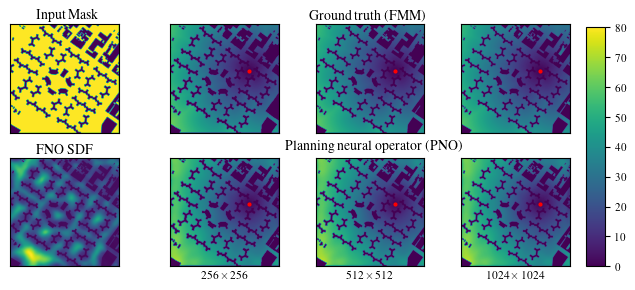

In [18]:
trainDataCity1024, testDataCity1024 = load_dataset("cityData/1024x1024", trainDataCount=0, testDataCount=1, batch_size=batch_size)
trainDataCity512, testDataCity512 = load_dataset("cityData/512x512", trainDataCount=0, testDataCount=1, batch_size=batch_size)
trainDataCity256, testDataCity256 = load_dataset("cityData/256x256", trainDataCount=0, testDataCount=1, batch_size=batch_size)

plot_paper_fig(testDataCity256, testDataCity512 , testDataCity1024,modelPNOwPINN, modelSDF,mask_func_arr[3], 0, "superResExampleNYC.pdf")

### Figure 7

In [120]:
def plot_example(model, modelPINN, modelSDF, mask_func_arr, data, example_num, filename, normalizer=None):
    set_ticks = True
    height_add = set_size(469, 0.99, (2, 3))[1]
    fig = plt.figure(figsize= set_size(469, 0.99, (2, 3),  height_add=height_add))
    subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)
    gs1 = subfigs.add_gridspec(2, 6, height_ratios=[1, 1])
    ax1a = subfigs.add_subplot(gs1[0, 0:2])
    ax2a = subfigs.add_subplot(gs1[0, 2:4])
    ax3a = subfigs.add_subplot(gs1[0, 4:6])
    ax4a = subfigs.add_subplot(gs1[1, 0:3])
    ax1 = subfigs.add_subplot(gs1[1, 3:6])

    axes1 = [ax1a, ax2a, ax3a, ax4a, ax1]
    subfigs.suptitle("Value functions and relative error between FMM (Unseen)", fontsize="x-large")

    # Get vmin, vmax
    vmin_top = np.inf
    vmax_top = -np.inf
    vmin_bottom = 0
    vmax_bottom = -np.inf
    loss_func = LpLoss(d=2, p=2)
    set_ticks = False
    vmin_top = 0
    vmax_top = 55
    # PLOT PINN model
    with torch.no_grad():
        for idx, (mask, chi,goals, y) in enumerate(data):
            chi = smooth_chi(mask, modelSDF(mask), 5)    
            out = modelPINN(chi, goals)
            if normalizer is not None:
                out = normalizer.decode(out) * mask_func(mask)
            else:
                out = out*mask    
            if idx == 1:
                break
        axes1[1].imshow(out[example_num].detach().cpu().numpy(), vmin=vmin_top, vmax=vmax_top, origin="lower")
        axes1[1].plot(goals[example_num][0].detach().cpu().numpy(), goals[example_num][1].detach().cpu().numpy(), 'ro')
        axes1[1].contour(out[example_num].reshape(out.shape[1], out.shape[2]).detach().cpu().numpy(),levels=30, colors="k",linewidths=0.3)
        im2 = axes1[4].imshow(torch.abs(out[example_num]-y[example_num]).detach().cpu().numpy(), vmin=0, vmax=5, origin="lower")

        axes1[1].set_title("PNO w/ PINN")
        axes1[4].set_title("PNO w/ \nPINN error")

        if set_ticks:
            axes1[1].set_xticks([0, 250, 500, 750, 1000])
            axes1[1].set_yticks([0, 250, 500, 750, 1000])

    # PLOT without PINN
    with torch.no_grad():
        for idx, (mask, chi,goals, y) in enumerate(data):
            chi = smooth_chi(mask, modelSDF(mask), 5)    
            out = model(chi, goals)
            if normalizer is not None:
                out = normalizer.decode(out) * mask_func(mask)
            else:
                out = out*mask    
            if idx == 1:
                break
    axes1[0].imshow(out[example_num].detach().cpu().numpy(), vmin=vmin_top, vmax=vmax_top, origin="lower")
    axes1[0].plot(goals[example_num][0].detach().cpu().numpy(), goals[example_num][1].detach().cpu().numpy(), 'ro')
    axes1[0].contour(out[example_num].reshape(out.shape[1], out.shape[2]).detach().cpu().numpy(),levels=30, colors="k",linewidths=0.3)
    axes1[0].set_title("PNO w/out PINN")

    # FMM EXAMPLE
    axes1[3].imshow(torch.abs(out[example_num]-y[example_num]).detach().cpu().numpy(), vmin=0, vmax=5, origin="lower")
    axes1[3].set_title("Error PNO \n w/out PINN ")
    if set_ticks:
        axes1[0].set_xticks([0, 250, 500, 750, 1000])
        axes1[0].set_yticks([0, 250, 500, 750, 1000])

    axes1[2].set_xticks([])  
    axes1[2].set_yticks([])    
    axes1[1].set_xticks([])  
    axes1[1].set_yticks([]) 
    axes1[0].set_xticks([])  
    axes1[0].set_yticks([])
    axes1[3].set_xticks([])  
    axes1[3].set_yticks([])
    axes1[4].set_xticks([])  
    axes1[4].set_yticks([])  
        
    y = y[example_num].detach().cpu().numpy()
    im = axes1[2].imshow(y,  cmap='viridis', vmin=vmin_top, vmax=vmax_top, origin="lower")
    axes1[2].plot(goals[example_num][0].detach().cpu().numpy(), goals[example_num][1].detach().cpu().numpy(), 'ro')
    axes1[2].contour(y[:, :, 0],levels=20, colors="k",linewidths=0.3)

    axes1[2].set_title("FMM")
    cb_ax = subfigs.add_axes([.91,.56,.02,.29])
    fig.colorbar(im, orientation='vertical',cax=cb_ax)
    #subfigs.subplots_adjust(left=0.05, bottom=0.03, right=.9, top=0.92, hspace=.32, wspace=0.5)

    cb_ax = subfigs.add_axes([.87,.11,.02,.35])
    fig.colorbar(im2, orientation='vertical',cax=cb_ax)
    plt.savefig(filename, dpi=300)
    plt.show()
    #subfigs.subplots_adjust(left=0.05, bottom=0.1, right=.9, top=0.85, hspace=.4, wspace=0.3)

def plot_example_grad(model, modelPINN, modelSDF, mask_func, data, example_num, filename, normalizer=None):
    set_ticks = True
    height_add = set_size(469, 0.99, (2, 3))[1]
    fig = plt.figure(figsize= set_size(469, 0.99, (2, 3),  height_add=height_add))
    subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)
    gs1 = subfigs.add_gridspec(2, 6)
    ax1a = subfigs.add_subplot(gs1[0, 0:2])
    ax2a = subfigs.add_subplot(gs1[0, 2:4])
    ax5a = subfigs.add_subplot(gs1[0, 4:6])

    ax3a = subfigs.add_subplot(gs1[1, 0:3])
    ax4a = subfigs.add_subplot(gs1[1, 3:6])

    axes1 = [ax1a, ax2a, ax3a, ax4a, ax5a]
    subfigs.suptitle(r"Gradient of value function ($\|\nabla V(x)\|$) and error \\ of gradient value function ($|\|\nabla V(x)\|-c(x)|$) (Seen)", fontsize="x-large")

    # Get vmin, vmax
    vmin_top = np.inf
    vmax_top = -np.inf
    vmin_bottom = 0
    vmax_bottom = -np.inf
    loss_func = LpLoss(d=2, p=2)
    set_ticks = False
    vmin_top = 0
    vmax_top = 2
    # PLOT PINN MODEL
    with torch.no_grad():
        for idx, (mask, chi,goals, y) in enumerate(data):
            chi = smooth_chi(mask, modelSDF(mask), 5)    
            out = modelPINN(chi, goals)
            if normalizer is not None:
                out = normalizer.decode(out) * mask_func(mask)
            else:
                out = out*mask    
            if idx == 1:
                break
    grad_out = torch.linalg.vector_norm(torch.stack(list(torch.gradient(out[example_num].reshape(1, out.shape[1], out.shape[2]), dim=[1, 2])), dim=0), dim=0)
    grad_y = torch.linalg.vector_norm(torch.stack(list(torch.gradient(y[example_num].reshape(1, y.shape[1], y.shape[2]), dim=[1, 2])), dim=0), dim=0)
    im= axes1[1].imshow(grad_out[0].detach().cpu().numpy(), vmin=vmin_top, vmax=vmax_top, origin="lower")
    axes1[1].plot(goals[example_num][0].detach().cpu().numpy(), goals[example_num][1].detach().cpu().numpy(), 'ro')

    axes1[1].set_title("PNO w/ PINN")
    
    if set_ticks:
        axes1[1].set_xticks([0, 250, 500, 750, 1000])
        axes1[1].set_yticks([0, 250, 500, 750, 1000])

    imOMEGA = axes1[3].imshow(torch.abs(grad_out[0]-grad_y[0]).detach().cpu().numpy(), vmin=0, vmax=1.5, origin="lower")
    axes1[3].set_title("PNO w PINN\n Gradient Error")
   
    with torch.no_grad():
        for idx, (mask, chi,goals, y) in enumerate(data):
            chi = smooth_chi(mask, modelSDF(mask), 5)    
            out = model(chi, goals)
            if normalizer is not None:
                out = normalizer.decode(out) * mask_func(mask)
            else:
                out = out*mask    
            if idx == 1:
                break

    grad_out = torch.linalg.vector_norm(torch.stack(list(torch.gradient(out[example_num].reshape(1, out.shape[1], out.shape[2]), dim=[1, 2])), dim=0), dim=0)
    grad_y = torch.linalg.vector_norm(torch.stack(list(torch.gradient(y[example_num].reshape(1, y.shape[1], y.shape[2]), dim=[1, 2])), dim=0), dim=0)
    
    axes1[4].imshow(grad_y[0].detach().cpu().numpy(), vmin=vmin_top, vmax=vmax_top, origin="lower")
    axes1[4].plot(goals[example_num][0].detach().cpu().numpy(), goals[example_num][1].detach().cpu().numpy(), 'ro')
    axes1[4].set_title("FMM")
    axes1[0].set_title("PNO w/out PINN")
    print(loss_func(grad_out.view(1, y.shape[1], y.shape[2]), grad_y.view(1, y.shape[1], y.shape[2])))
    axes1[0].imshow(grad_out[0].detach().cpu().numpy(), vmin=vmin_top, vmax=vmax_top, origin="lower")
    axes1[0].plot(goals[example_num][0].detach().cpu().numpy(), goals[example_num][1].detach().cpu().numpy(), 'ro')
    if set_ticks:
        axes1[0].set_xticks([0, 250, 500, 750, 1000])
        axes1[0].set_yticks([0, 250, 500, 750, 1000])
    axes1[2].imshow(torch.abs(grad_out[0]-grad_y[0]).detach().cpu().numpy(), vmin=0, vmax=1.5, origin="lower")
    axes1[2].set_title("PNO w/out PINN\n Gradient Error")
    axes1[2].set_xticks([])  
    axes1[2].set_yticks([])    
    axes1[1].set_xticks([])  
    axes1[1].set_yticks([]) 
    axes1[0].set_xticks([])  
    axes1[0].set_yticks([])
    axes1[3].set_xticks([])  
    axes1[3].set_yticks([])  
    axes1[4].set_xticks([])  
    axes1[4].set_yticks([])

    cb_ax = subfigs.add_axes([.91,.54,.02,.33])
    fig.colorbar(im, orientation='vertical',cax=cb_ax)
    #subfigs.subplots_adjust(left=0.05, bottom=0.0, right=.9, top=1, hspace=-0.3, wspace=0.5)

    cb_ax = subfigs.add_axes([.91,.13,.02,.33])
    fig.colorbar(imOMEGA, orientation='vertical',cax=cb_ax)
    plt.savefig(filename, dpi=300)
    plt.show()
    #subfigs.subplots_adjust(left=0.05, bottom=0.1, right=.9, top=0.85, hspace=.4, wspace=0.3)

Load dataset complete(train size, test size) 800 200


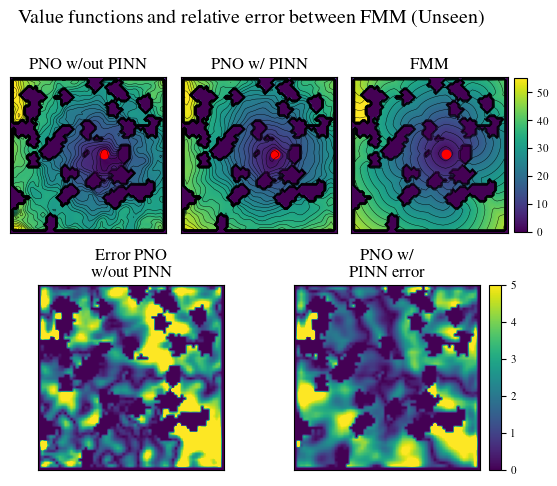

tensor(0.1305, device='cuda:0')


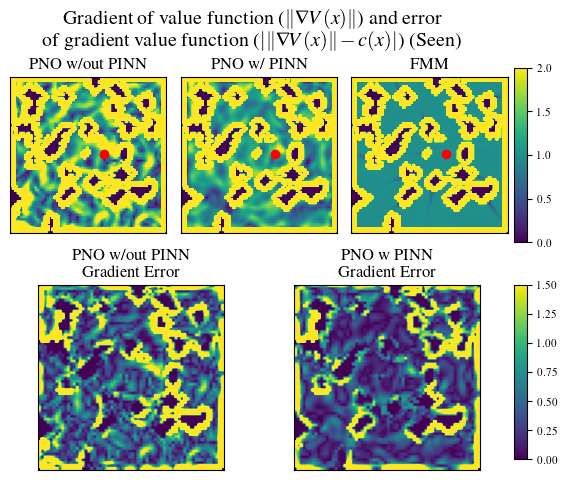

In [122]:
trainData64, testData64 = load_dataset("synthetic/64x64", trainDataCount=0.8, testDataCount=0.2, batch_size=20)

# We plot an example with a goal in the center for clarity - but one can visualize many different examples by changing the number 2 to 
# any number between [0, batch_size). 
plot_example(modelPNO, modelPNOwPINN, modelSDF, mask_func_arr[2], testData64, 2, "pinnOUTDIST2.pdf")
plot_example_grad(modelPNO, modelPNOwPINN, modelSDF, mask_func_arr[2], testData64, 2, "pinnGradOUTDIST2.pdf")